In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from tqdm import tqdm

In [2]:
df = pd.read_csv(r'Z:/nia_summer_project/data_transfer/videos/VideoOutputCamera 2-29072022-115137DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.csv', low_memory=False)
df

,scorer,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.1,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.2,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.3,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.4,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.5,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.6,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.7,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.8,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.9,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.10,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.11,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.12,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.13,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.14,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.15,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.16,DLC_resnet50_OpenFieldHighResApr8shuffle1_600000.17
0,bodyparts,Snout,Snout,Snout,Front Paw R,Front Paw R,Front Paw R,Front Paw L,Front Paw L,Front Paw L,Hind Paw R,Hind Paw R,Hind Paw R,Hind Paw L,Hind Paw L,Hind Paw L,Butt/Proximal Tail,Butt/Proximal Tail,Butt/Proximal Tail
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,0,747.4931030273438,482.8681335449219,0.950119137763977,751.8052978515625,517.184326171875,0.5268877148628235,737.616943359375,540.3986206054688,0.6786713600158691,737.3895874023438,537.3734741210938,0.07680091261863708,738.25537109375,583.082275390625,0.3334735929965973,339.0918884277344,610.551513671875,0.03713107109069824
3,1,289.4408264160156,40.26938247680664,0.5673515796661377,755.5013427734375,491.0885009765625,0.4936246871948242,750.6339111328125,523.2803955078125,0.8640628457069397,738.3594360351562,582.1358032226562,0.08540964126586914,738.1847534179688,581.8896484375,0.7125677466392517,710.4632568359375,545.8712158203125,0.07977747917175293
4,2,724.7617797851562,483.935546875,0.6089091897010803,753.478271484375,516.918701171875,0.842714786529541,753.7506103515625,519.5599975585938,0.5110982060432434,756.7841796875,488.5967102050781,0.6270039677619934,738.1229248046875,581.4165649414062,0.9227966070175171,729.0597534179688,484.3116760253906,0.7873262166976929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16510,16508,717.9221801757812,584.45458984375,0.9828971028327942,759.28662109375,564.950927734375,0.9822357296943665,751.4193725585938,564.9307861328125,0.9919966459274292,770.3936767578125,517.8088989257812,0.9989598393440247,733.9376831054688,548.0542602539062,0.997972309589386,735.56396484375,495.17364501953125,0.9982150793075562
16511,16509,716.5028686523438,584.0814819335938,0.9815191626548767,760.1832275390625,566.277587890625,0.9898059368133545,751.159912109375,565.8387451171875,0.9855007529258728,769.2095336914062,517.1781616210938,0.9989617466926575,735.4276733398438,548.477783203125,0.9978716373443604,735.2315063476562,496.9817199707031,0.9984485507011414
16512,16510,714.3448486328125,581.1865844726562,0.9835890531539917,761.5081176757812,568.0121459960938,0.9919307231903076,752.5736694335938,567.316650390625,0.9755645990371704,770.0189208984375,517.3814086914062,0.9987304210662842,735.4203491210938,548.6294555664062,0.9903181791305542,738.1747436523438,500.1313781738281,0.998762309551239
16513,16511,712.0139770507812,576.58154296875,0.937470555305481,761.8499755859375,567.767333984375,0.9774643182754517,749.21923828125,568.908203125,0.9918744564056396,768.6072387695312,516.42138671875,0.9984499216079712,735.49658203125,549.3140258789062,0.994964599609375,738.3170166015625,499.11517333984375,0.9985163807868958


In [5]:
with open('Z:/nia_summer_project/data_transfer/bsoid_behavioral_model/openfield_60min_N6_randomforest.sav', 'rb') as fr:
    random_forest_sav = joblib.load(fr)

c:\users\alexa\anaconda3\envs\bsoid_v2\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\alexa\anaconda3\envs\bsoid_v2\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
clf = random_forest_sav[3]
clf

RandomForestClassifier(random_state=42)

In [7]:
def adp_filt(currdf: object, pose):
    lIndex = []
    xIndex = []
    yIndex = []
    currdf = np.array(currdf[1:])
    for header in pose:
        if currdf[0][header + 1] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header + 1] == "x":
            xIndex.append(header)
        elif currdf[0][header + 1] == "y":
            yIndex.append(header)
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[1:, np.array(xIndex)]
    datay = curr_df1[1:, np.array(yIndex)]
    data_lh = curr_df1[1:, np.array(lIndex)]
    currdf_filt = np.zeros((datax.shape[0], (datax.shape[1]) * 2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = b[rise_a[0][0]]
        else:
            llh = b[rise_a[0][1]]
        llh=0
        data_lh_float = data_lh[:, x].astype(np.float)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        currdf_filt[0, (2 * x):(2 * x + 2)] = np.hstack([datax[0, x], datay[0, x]])
        for i in range(1, data_lh.shape[0]):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt)
    currdf_filt = currdf_filt.astype(np.float)
    return currdf_filt, perc_rect

In [8]:
csv_array_filtered, perc_filtered = adp_filt(df, np.arange(18))

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


In [9]:
perc_filtered

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [10]:
# csv_array.shape
processed_input_data = [csv_array_filtered.copy()]

In [11]:
framerate=30
window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)

In [12]:
def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg

In [13]:
a = [1, 2, 1, 2, 1, 2, 3, 4, 5, 4, 3, 2, 1]
a_smoothed = boxcar_center(a, n=window)

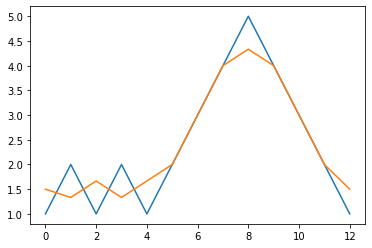

In [14]:
plt.plot(a)
plt.plot(a_smoothed)

In [15]:
framerate = 30
window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
f = []
for n in range(len(processed_input_data)):
    data_n_len = len(processed_input_data[n])
    dxy_list = []
    disp_list = []
    for r in range(data_n_len):
        if r < data_n_len - 1:
            disp = []
            for c in range(0, processed_input_data[n].shape[1], 2):
                disp.append(
                    np.linalg.norm(processed_input_data[n][r + 1, c:c + 2] -
                                   processed_input_data[n][r, c:c + 2]))
            disp_list.append(disp)
        dxy = []
        for i, j in itertools.combinations(range(0, processed_input_data[n].shape[1], 2), 2):
            dxy.append(processed_input_data[n][r, i:i + 2] -
                       processed_input_data[n][r, j:j + 2])
        dxy_list.append(dxy)
    disp_r = np.array(disp_list)
    dxy_r = np.array(dxy_list)
    disp_boxcar = []
    dxy_eu = np.zeros([data_n_len, dxy_r.shape[1]])
    ang = np.zeros([data_n_len - 1, dxy_r.shape[1]])
    dxy_boxcar = []
    ang_boxcar = []
    for l in range(disp_r.shape[1]):
#         disp_boxcar.append(boxcar_center(disp_r[:, l], window))
        disp_boxcar.append(disp_r[:, l])
    for k in range(dxy_r.shape[1]):
        for kk in range(data_n_len):
            dxy_eu[kk, k] = np.linalg.norm(dxy_r[kk, k, :])
            if kk < data_n_len - 1:
                b_3d = np.hstack([dxy_r[kk + 1, k, :], 0])
                a_3d = np.hstack([dxy_r[kk, k, :], 0])
                c = np.cross(b_3d, a_3d)
                ang[kk, k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                    math.atan2(np.linalg.norm(c),
                                               np.dot(dxy_r[kk, k, :], dxy_r[kk + 1, k, :])))
#         dxy_boxcar.append(boxcar_center(dxy_eu[:, k], window))
#         ang_boxcar.append(boxcar_center(ang[:, k], window))
        dxy_boxcar.append(dxy_eu[:, k])
        ang_boxcar.append(ang[:, k])
    disp_feat = np.array(disp_boxcar)
    dxy_feat = np.array(dxy_boxcar)
    ang_feat = np.array(ang_boxcar)
    f.append(np.vstack((dxy_feat[:, 1:], ang_feat, disp_feat)))

for m in range(0, len(f)):
    f_integrated = np.zeros(len(processed_input_data[m]))
    for k in range(round(framerate / 10), len(f[m][0]), round(framerate / 10)):
        if k > round(framerate / 10):
            f_integrated = np.concatenate(
                (f_integrated.reshape(f_integrated.shape[0], f_integrated.shape[1]),
                 np.hstack((np.mean((f[m][0:dxy_feat.shape[0],
                                     range(k - round(framerate / 10), k)]), axis=1),
                            np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                                    range(k - round(framerate / 10), k)]), axis=1)
                            )).reshape(len(f[0]), 1)), axis=1
            )
        else:
            f_integrated = np.hstack(
                (np.mean((f[m][0:dxy_feat.shape[0], range(k - round(framerate / 10), k)]), axis=1),
                 np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                         range(k - round(framerate / 10), k)]), axis=1))).reshape(len(f[0]), 1)
    if m > 0:
        features = np.concatenate((features, f_integrated), axis=1)
    else:
        features = f_integrated

In [16]:
f[0].shape, features.T.shape

((36, 16512), (5503, 36))

In [17]:
X = features.T.copy()
predictions = clf.predict(X)

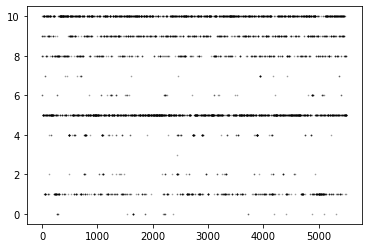

In [18]:
plt.scatter(np.arange(len(predictions)), predictions, s=0.5, color='k', alpha=0.3)

In [19]:
len(np.where(predictions==9)[0])
len(np.where(np.diff(np.where(predictions==9)[0]) !=1)[0])

421

In [20]:
stim_time = np.where(predictions==9)[0][np.where(np.diff(np.where(predictions==9)[0]) !=1)[0]]

(0.0, 545.4)

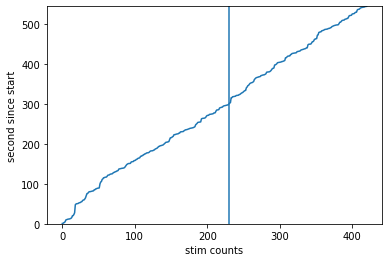

In [21]:
fig, ax = plt.subplots(1, 1)
ax.plot(stim_time/10)
ax.set_xlabel('stim counts')
ax.set_ylabel('second since start')
ax.vlines(np.where(stim_time/10 > 300)[0][0], 0, (stim_time/10).max())
ax.set_ylim([0, (stim_time/10).max()])

In [22]:
np.save('../tmp/posthoc_trial1_orientL.npy', np.array(stim_time)/10)

In [20]:
bin_start = np.arange(0, np.max(stim_time), 600)
bin_end = np.arange(600, np.max(stim_time)+600, 600)
print(bin_start, bin_end)
stim_binned_counts = []
for b in range(len(bin_start)):
    stim_binned_counts.append(len(np.where((stim_time >= bin_start[b]) 
                                           & (stim_time < bin_end[b]))[0]))

[   0  600 1200 1800 2400 3000 3600 4200 4800 5400] [ 600 1200 1800 2400 3000 3600 4200 4800 5400 6000]


<BarContainer object of 10 artists>

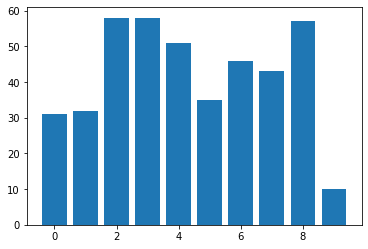

In [21]:
plt.bar(np.arange(len(stim_binned_counts)), stim_binned_counts)

<BarContainer object of 10 artists>

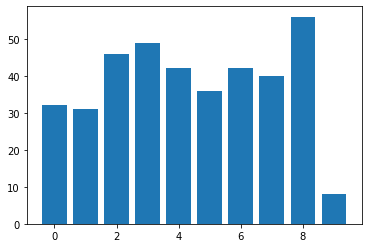

In [90]:
plt.bar(np.arange(len(stim_binned_counts)), stim_binned_counts)

In [106]:
print(np.mean(stim_binned_counts))

42.0


In [82]:
np.where(np.diff(np.where(predictions==9)[0]) !=1)[0]

array([  0,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,  16,
        18,  20,  21,  23,  27,  28,  29,  31,  33,  35,  37,  38,  40,
        42,  44,  45,  47,  50,  52,  54,  55,  57,  60,  61,  65,  66,
        67,  68,  70,  71,  72,  74,  75,  77,  78,  79,  81,  82,  83,
        85,  88,  91,  95,  96, 101, 102, 104, 105, 106, 107, 110, 111,
       113, 116, 119, 120, 122, 124, 125, 126, 130, 134, 135, 138, 140,
       142, 143, 144, 150, 151, 152, 153, 154, 155, 157, 158, 162, 164,
       165, 166, 168, 169, 170, 171, 174, 175, 176, 177, 180, 182, 184,
       186, 190, 193, 194, 195, 196, 197, 198, 200, 202, 205, 206, 208,
       209, 210, 211, 215, 216, 218, 219, 220, 221, 226, 227, 229, 230,
       231, 234, 235, 238, 239, 241, 242, 243, 244, 245, 249, 250, 251,
       252, 256, 257, 258, 259, 261, 262, 264, 266, 268, 270, 271, 272,
       274, 275, 276, 277, 279, 280, 282, 283, 285, 286, 287, 289, 290,
       291, 293, 294, 295, 296, 299, 300, 301, 302, 303, 304, 30

In [ ]:
snout_x = np.array(df.iloc[2:100, 1])
snout_y = np.array(df.iloc[2:100, 2])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snout_x, snout_y, np.arange(len(snout_x)), s=100, c='k')
ax.set_xlim([0, 1000])
plt.show()

In [ ]:
snout_x.shape, snout_y.shape, len(snout_x), snout_x, snout_y